<a href="https://colab.research.google.com/github/zesto-shoaib/Indian-House-Prediction/blob/main/IHP_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
!pip install category_encoders
import category_encoders as ce
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Creating Dataframe from the dataset

In [2]:
df = pd.read_csv('train.csv')

In [3]:
df.shape

(29451, 12)

In [4]:
df.columns

Index(['POSTED_BY', 'UNDER_CONSTRUCTION', 'RERA', 'BHK_NO.', 'BHK_OR_RK',
       'SQUARE_FT', 'READY_TO_MOVE', 'RESALE', 'ADDRESS', 'LONGITUDE',
       'LATITUDE', 'TARGET(PRICE_IN_LACS)'],
      dtype='object')

Checking if the dataframe contains any null values

In [5]:
df.isnull().sum()

POSTED_BY                0
UNDER_CONSTRUCTION       0
RERA                     0
BHK_NO.                  0
BHK_OR_RK                0
SQUARE_FT                0
READY_TO_MOVE            0
RESALE                   0
ADDRESS                  0
LONGITUDE                0
LATITUDE                 0
TARGET(PRICE_IN_LACS)    0
dtype: int64

In [6]:
df.head()

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0
3,Owner,0,1,2,BHK,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5
4,Dealer,1,0,2,BHK,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5


Getting the city from the address column

In [7]:
df['CITY'] = df['ADDRESS'].str.split(',').str.get(-1)

Checking the values from the column BHK_or_Rk and since RK corresponds to only 24 datapoints, we drop those rows, and then the column

In [8]:
df['BHK_OR_RK'].value_counts()

BHK    29427
RK        24
Name: BHK_OR_RK, dtype: int64

In [9]:
df.drop(df[df['BHK_OR_RK'] == 'RK'].index, inplace = True)

In [10]:
df.shape

(29427, 13)

In [11]:
df.drop('BHK_OR_RK', axis = 'columns', inplace = True)

We see that there are multiple cities with very less data points corresponding to them, so we categorise all such cities and put them in other category

In [12]:
city_stats = df['CITY'].value_counts()

In [13]:
city_stats_less_than_10 = city_stats[city_stats < 10]

In [14]:
df['CITY'] = df['CITY'].apply(lambda x: 'other' if x in city_stats_less_than_10 else x)

In [15]:
len(df['CITY'].unique())

116

#Removing Outliers

We remove the rows that have a room measuring less than 180 sq.ft.

In [16]:
df[df['SQUARE_FT']/df['BHK_NO.'] < 180].head()

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS),CITY
236,Owner,0,0,3,534.061239,1,1,"Sector 55 Faridabad,Faridabad",28.345320,77.299035,45.0,Faridabad
1064,Dealer,1,1,2,345.276221,0,0,"Ravet,Pune",18.651598,73.735448,34.5,Pune
1254,Dealer,0,0,4,194.594595,1,1,"Beldih charch school,Jamshedpur",22.923869,86.305133,180.0,Jamshedpur
2092,Owner,0,0,2,5.000000,1,1,"Sector-29 Chandigarh,Chandigarh",30.755000,76.777256,45.0,Chandigarh
2323,Owner,0,0,2,49.800797,1,1,"Civil Lines,Nagpur",21.152819,79.069531,30.0,Nagpur


In [17]:
df.drop(df[df['SQUARE_FT']/df['BHK_NO.'] < 180].index,inplace=True)

In [18]:
df.shape

(29366, 12)

We define a new column by calculating price per square feet to perform further cleaning.

In [19]:
df['Price_Per_Sq_Ft'] = df['TARGET(PRICE_IN_LACS)']*100000/df['SQUARE_FT']

In [20]:
df['Price_Per_Sq_Ft'].describe()

count     29366.000000
mean       7375.381428
std        8055.693006
min           1.000000
25%        3548.000001
50%        5086.999999
75%        8019.500000
max      466666.000008
Name: Price_Per_Sq_Ft, dtype: float64

(array([ 2580., 11315.,  5271.,  1915.,   879.,   832.,   665.,   432.,
          302.,   207.]),
 array([  144.99999997,  2822.80000059,  5500.6000012 ,  8178.40000182,
        10856.20000244, 13534.00000305, 16211.80000367, 18889.60000429,
        21567.4000049 , 24245.20000552, 26923.00000614]),
 <a list of 10 Patch objects>)

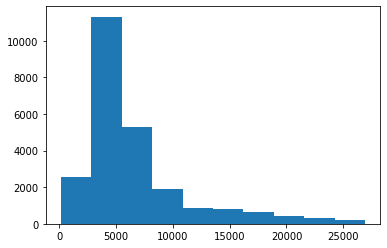

In [58]:
plt.hist(df2.Price_Per_Sq_Ft)

We can observe that there are outliers in the data through the new column.

In [21]:
df2 = pd.DataFrame()
for city, city_df in df.groupby('CITY'):
  m = np.mean(city_df.Price_Per_Sq_Ft)
  st = np.std(city_df.Price_Per_Sq_Ft)
  reduced_df = city_df[(city_df.Price_Per_Sq_Ft>(m-st)) & (city_df.Price_Per_Sq_Ft<=(m+st))]
  df2 = pd.concat([df2,reduced_df],ignore_index=True)

In [22]:
df2.shape

(24398, 13)

In [23]:
df2['Price_Per_Sq_Ft'].describe()

count    24398.000000
mean      6589.752439
std       4687.862926
min        145.000000
25%       3619.000000
50%       5020.000001
75%       7534.500001
max      26923.000006
Name: Price_Per_Sq_Ft, dtype: float64

We check the relationship between the target price and the posted by column

In [24]:
df2[df2['POSTED_BY']=='Owner'].Price_Per_Sq_Ft.describe()

count     8695.000000
mean      4273.272685
std       1684.116425
min        145.000000
25%       3111.000000
50%       4055.000000
75%       5139.499998
max      26119.000000
Name: Price_Per_Sq_Ft, dtype: float64

In [25]:
df2[df2['POSTED_BY']=='Dealer'].Price_Per_Sq_Ft.describe()

count    15229.000000
mean      7956.221223
std       5316.519659
min        637.000000
25%       4156.000000
50%       6153.000000
75%       9625.000000
max      26923.000006
Name: Price_Per_Sq_Ft, dtype: float64

In [26]:
df2[df2['POSTED_BY']=='Builder'].Price_Per_Sq_Ft.describe()

count      474.000000
mean      5180.128692
std       3261.110303
min       1200.000000
25%       3250.000001
50%       4399.500000
75%       6000.000000
max      26414.999999
Name: Price_Per_Sq_Ft, dtype: float64

In [27]:
df['TARGET(PRICE_IN_LACS)'].describe()

count    29366.000000
mean       143.188247
std        657.803605
min          0.250000
25%         38.000000
50%         62.000000
75%        100.000000
max      30000.000000
Name: TARGET(PRICE_IN_LACS), dtype: float64

We plot some graphs to know more about the remaining columns.

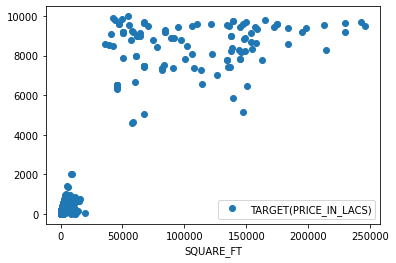

In [28]:
df2.plot(x = 'SQUARE_FT', y = 'TARGET(PRICE_IN_LACS)', style = 'o')

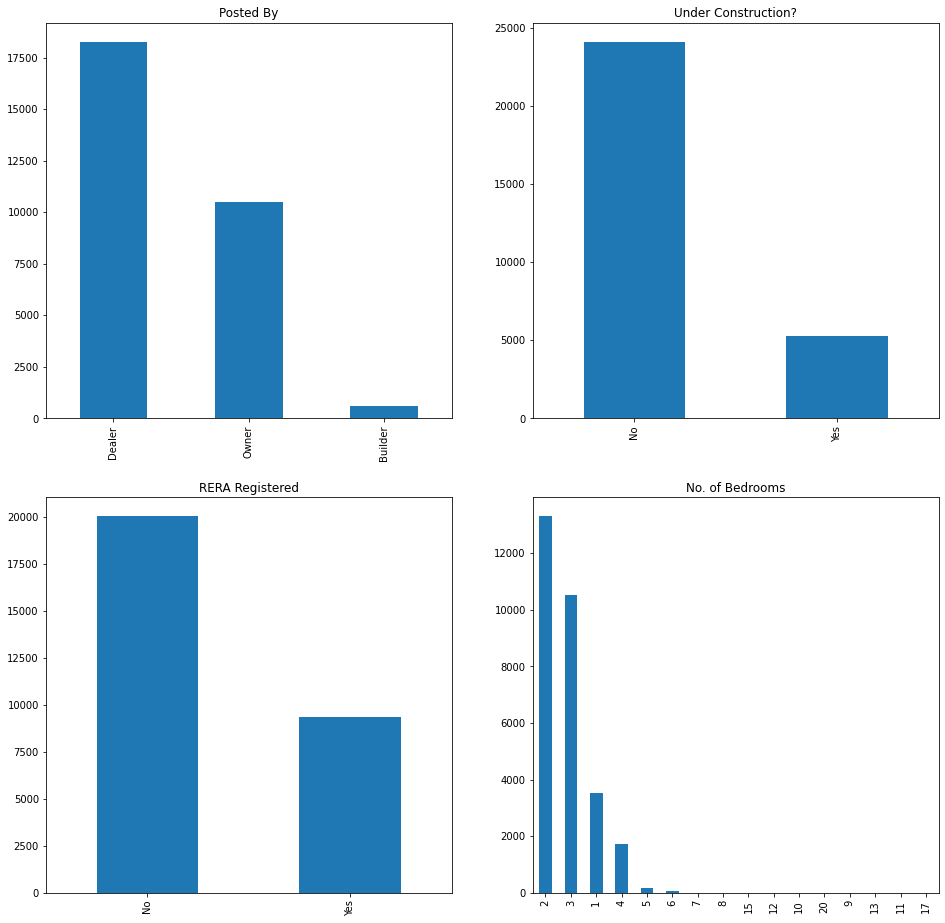

In [30]:
plt.subplot(221)
df['POSTED_BY'].value_counts().plot(kind = 'bar', figsize = (16,16), title = 'Posted By')

plt.subplot(222)
df['UNDER_CONSTRUCTION'].value_counts().plot(kind = 'bar', title = 'Under Construction?')
plt.xticks((0,1), ('No','Yes'))

plt.subplot(223)
df['RERA'].value_counts().plot(kind = 'bar', title = 'RERA Registered')
plt.xticks((0,1), ('No','Yes'))

plt.subplot(224)
df['BHK_NO.'].value_counts().plot(kind = 'bar', title = 'No. of Bedrooms')

([<matplotlib.axis.XTick at 0x7fc07ad3ea90>,
 [Text(0, 0, 'No'), Text(0, 0, 'Yes')])

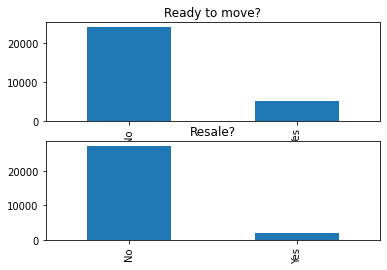

In [31]:
plt.subplot(211)
df['READY_TO_MOVE'].value_counts().plot(kind = 'bar', title = 'Ready to move?')
plt.xticks((0,1), ('No','Yes'))

plt.subplot(212)
df['RESALE'].value_counts().plot(kind = 'bar',title = 'Resale?')
plt.xticks((0,1), ('No','Yes'))

In [32]:
df2.head()

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS),CITY,Price_Per_Sq_Ft
0,Dealer,0,0,4,2750.929368,1,1,"Sikandra,Agra",27.216013,77.950834,74.0,Agra,2690.000000
1,Owner,0,1,2,1250.000000,1,1,"Shastripuram,Agra",27.553339,78.673469,32.0,Agra,2560.000000
2,Dealer,0,0,2,1237.381960,1,1,"Shastripuram,Agra",27.553339,78.673469,38.0,Agra,3071.000001
3,Owner,0,1,3,1550.387597,1,1,"Taj Nagari,Agra",27.180000,78.020000,48.0,Agra,3096.000000
4,Owner,0,1,3,1604.464597,1,1,"Shastripuram,Agra",27.553339,78.673469,46.0,Agra,2867.000000


In [33]:
df3 = df2.copy()

We firstly perform One Hot Encoding on the categorical data and then use Linear Regression to train the data.

In [34]:
df_dummies_city = pd.get_dummies(df2['CITY'])
df_dummies_posted_by = pd.get_dummies(df2['POSTED_BY'])

In [35]:
print(df_dummies_city.columns)
print(df_dummies_posted_by.columns)

Index(['Agra', 'Ahmednagar', 'Ajmer', 'Aligarh', 'Allahabad', 'Alwar',
       'Amravati', 'Amritsar', 'Anand', 'Asansol',
       ...
       'Udupi', 'Vadodara', 'Valsad', 'Vapi', 'Varanasi', 'Vijayawada',
       'Visakhapatnam', 'Vizianagaram', 'Wardha', 'other'],
      dtype='object', length=116)
Index(['Builder', 'Dealer', 'Owner'], dtype='object')


In [36]:
df2 = pd.concat([df2,df_dummies_city.drop('other', axis = 'columns'),df_dummies_posted_by.drop('Builder',axis='columns')],axis='columns')

In [37]:
df2.head(3)

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS),CITY,Price_Per_Sq_Ft,Agra,Ahmednagar,Ajmer,Aligarh,Allahabad,Alwar,Amravati,Amritsar,Anand,Asansol,Aurangabad,Bahadurgarh,Bangalore,Belgaum,Bharuch,Bhavnagar,Bhilai,Bhiwadi,Bhopal,Bhubaneswar,Bilaspur,Chandigarh,Chandrapur,Chennai,Coimbatore,Dehradun,Dhanbad,...,Navsari,Neemrana,Nellore,Noida,Palakkad,Palghar,Panaji,Panchkula,Patna,Pondicherry,Pune,Puri,Raigad,Raipur,Rajkot,Ranchi,Ratnagiri,Rudrapur,Secunderabad,Shimla,Siliguri,Sindhudurg,Solan,Solapur,Sonipat,Surat,Thrissur,Tirupati,Udaipur,Udupi,Vadodara,Valsad,Vapi,Varanasi,Vijayawada,Visakhapatnam,Vizianagaram,Wardha,Dealer,Owner
0,Dealer,0,0,4,2750.929368,1,1,"Sikandra,Agra",27.216013,77.950834,74.0,Agra,2690.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,Owner,0,1,2,1250.000000,1,1,"Shastripuram,Agra",27.553339,78.673469,32.0,Agra,2560.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,Dealer,0,0,2,1237.381960,1,1,"Shastripuram,Agra",27.553339,78.673469,38.0,Agra,3071.000001,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [38]:
X_one_hot = df2.drop(['POSTED_BY','ADDRESS','LONGITUDE','LATITUDE','CITY','Price_Per_Sq_Ft','TARGET(PRICE_IN_LACS)'], axis = 'columns')

In [39]:
Y_one_hot = df2['TARGET(PRICE_IN_LACS)']

In [40]:
x_train,x_test,y_train,y_test = train_test_split(X_one_hot,Y_one_hot,test_size = 0.2,random_state = 10)

In [41]:
model_lr = LinearRegression()

In [42]:
model_lr.fit(x_train,y_train)

LinearRegression()

In [43]:
model_lr.score(x_test,y_test)

0.8102298621999514

We now perform Target Encoding over the categorical data and then use Linear Regression to train the data.

In [44]:
encoder = ce.TargetEncoder(cols = ['CITY'])

In [45]:
df3['CITY'] = encoder.fit_transform(df3['CITY'], df3['TARGET(PRICE_IN_LACS)'])

In [46]:
encoder = ce.TargetEncoder(cols = ['POSTED_BY'])

In [47]:
df3['POSTED_BY'] = encoder.fit_transform(df3['POSTED_BY'], df3['TARGET(PRICE_IN_LACS)'])

In [48]:
X_target = df3.drop(['ADDRESS','LONGITUDE','LATITUDE','Price_Per_Sq_Ft','TARGET(PRICE_IN_LACS)'], axis = 'columns')

In [49]:
Y_target = df3['TARGET(PRICE_IN_LACS)']

In [50]:
x_train,x_test,y_train,y_test = train_test_split(X_target,Y_target,test_size = 0.2,random_state = 10)

In [51]:
model_lr.fit(x_train,y_train)

LinearRegression()

In [52]:
model_lr.score(x_test,y_test)

0.8047739636921277

We see that they both give similar results.

In [ ]:
We now measure accuracy of our model by using K Fold Cross Validation

In [53]:
cv = ShuffleSplit(n_splits=5, test_size=0.2)

cross_val_score(LinearRegression(), X_one_hot, Y_one_hot, cv=cv)

array([0.76346206, 0.81497499, 0.764587  , 0.80411557, 0.76315473])

In [54]:
cv = ShuffleSplit(n_splits=5, test_size=0.2)

cross_val_score(LinearRegression(), X_target, Y_target, cv=cv)

array([0.77186218, 0.79490543, 0.78016819, 0.76222822, 0.84397561])

We now use GridSearchCV to compare between multiple algorithms using both the approaches of encoding.

In [55]:
def gridsearchcv(X,Y):
    algos = {
        'Linear Regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'Lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'Random Forest Regressor': {
            'model': RandomForestRegressor(),
            'params': {
                'max_depth': [80, 90],
                'max_features': [2, 3],
               'min_samples_leaf': [3, 4]
            }
        },
        'Decision Tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2)
    for algo_name, parameter in algos.items():
        gs =  GridSearchCV(parameter['model'], parameter['params'], cv=cv, return_train_score=False)
        gs.fit(X,Y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])


In [56]:
gridsearchcv(X_one_hot, Y_one_hot)

,model,best_score,best_params
0,Linear Regression,0.803722,{'normalize': False}
1,Lasso,0.792019,"{'alpha': 1, 'selection': 'cyclic'}"
2,Random Forest Regressor,0.583212,"{'max_depth': 80, 'max_features': 3, 'min_samp..."
3,Decision Tree,0.977521,"{'criterion': 'friedman_mse', 'splitter': 'best'}"


In [57]:
gridsearchcv(X_target, Y_target)

,model,best_score,best_params
0,Linear Regression,0.813774,{'normalize': True}
1,Lasso,0.787663,"{'alpha': 1, 'selection': 'random'}"
2,Random Forest Regressor,0.976648,"{'max_depth': 90, 'max_features': 3, 'min_samp..."
3,Decision Tree,0.979505,"{'criterion': 'friedman_mse', 'splitter': 'best'}"


We observe that Random Forest Regressor and Decision Tree perform best by Target Encoding.